# Introduction

This notebook is designed to visually walk through the steps to determine the optimal global bandwidth for a set of b-tagging, "MC $\rightarrow$ data" scale factors (SF) as well as the associated statistical and systematic uncertainties. It uses the local polynomial kernel estimator found in this package to "smooth" the distributions.

__requirements:__ 
* `rootpy`
* `ipython`
* `CDIFiles` package
    * located here: `atlasoff/PhysicsAnalysis/JetTagging/JetTagPerformanceCalibration/CDIFiles/trunk`
* `CalibrationDataInterface` package
    * located here: `atlasoff/PhysicsAnalysis/JetTagging/JetTagPerformanceCalibration/CalibrationDataInterface/trunk`
    * needs to be compiled before running this notebook
* `NPandSmoothingTools` package
    * located here: `atlasperf/CombPerf/FlavorTag/JetTagPerformanceCalibration/NPandSmoothingTools/trunk`
    * needs to be compiled before running this notebook

## Common Imports

In [1]:
import collections
import ROOT
import rootpy
from rootpy.plotting import Hist, Canvas, Legend, set_style

# now import RootCore stuff
rootCore_import_result = ROOT.gROOT.Macro('$ROOTCOREDIR/scripts/load_packages.C')
if rootCore_import_result != 0 and rootCore_import_result != 1:
    print "Couldn't import RootCore package libraries. Aborting..."
else:
    from ROOT import Analysis
    from ROOT.Analysis import ROOTHistogramSmoother#, optimizeLeaveOneOutCrossValidation
    from ROOT.Analysis import CalibrationDataHistogramContainer

## Custom Python wrappers

In [2]:
# make Python friendly class wrapper
class PyHistogramSmoother(ROOTHistogramSmoother):
    def __init__(self):
        #ROOTHistogramSmoother.__init(self)__
        super(PyHistogramSmoother, self).__init__()
        # maps to cache the ROOT objects
        self._call_args = {}
        self._AddDataPoint_args = {}
        self._SetDataPoint_args = {}
    
    # need this b/c ROOT has difficulty exporting the templated operator()
    def __call__(self, *args):
        nargs = len(args)
        c = None
        if nargs == 1 and isinstance(args[0], collections.Iterable):
            arg = args[0]
            size = len(arg)
            c = None
            if not size in self._call_args:
                self._call_args[size] = ROOTHistogramSmoother.Covariates_t(size)
            c = self._call_args[size]
            for i in range(size):
                c[i] = arg[i]
            return super(PyHistogramSmoother, self).__call__(c)
        else:
            if not nargs in self._call_args:
                self._call_args[nargs] = ROOTHistogramSmoother.Covariates_t(nargs)
            c = self._call_args[nargs]
            for i in range(nargs):
                c[i] = args[i]
        return super(PyHistogramSmoother, self).__call__(c)
    
    # added this only for uniformity with operator()
    def AddDataPoint(self, *args):
        nargs = len(args)
        c = None
        if nargs == 1 and isinstance(args[0], collections.Iterable):
            arg = args[0]
            size = len(arg)
            c = None
            if not size in self._call_args:
                self._AddDataPoint_args[size] = ROOTHistogramSmoother.FullCoord_t(size)
            c = self._AddDataPoint_args[size]
            for i in range(size):
                c[i] = arg[i]
            return super(PyHistogramSmoother, self).__call__(c)
        else:
            if not nargs in self._call_args:
                self._AddDataPoint_args[nargs] = ROOTHistogramSmoother.FullCoord_t(nargs)
            c = self._AddDataPoint_args[nargs]
            for i in range(nargs):
                c[i] = args[i]
        return super(PyHistogramSmoother, self).AddDataPoint(c)
    
    # added this only for uniformity with operator()
    def SetDataPoint(self, index, *args):
        nargs = len(args)
        c = None
        if nargs == 1 and isinstance(args[0], collections.Iterable):
            arg = args[0]
            size = len(arg)
            c = None
            if not size in self._call_args:
                self._SetDataPoint_args[size] = ROOTHistogramSmoother.FullCoord_t(size)
            c = self._SetDataPoint_args[size]
            for i in range(size):
                c[i] = arg[i]
            return super(PyHistogramSmoother, self).__call__(c)
        else:
            if not nargs in self._call_args:
                self._SetDataPoint_args[nargs] = ROOTHistogramSmoother.FullCoord_t(nargs)
            c = self._SetDataPoint_args[nargs]
            for i in range(nargs):
                c[i] = args[i]
        return super(PyHistogramSmoother, self).SetDataPoint(index, c)

# Demonstration of the Smoother and Cross Validation

## Setup smoothing object

In [3]:
smoother = PyHistogramSmoother()
smoother.SetNumberOfDataPoints(0)
smoother.SetDimension(1)
smoother.SetOrder(1)
smoother.SetBandwidth(0, 0.4)
smoother.SetNbins(0, 100)
smoother.SetScaleFunction(0, ROOT.TF1("ln scale", "TMath::Log(x)", -1.0, 1.0))
smoother.SetInvScaleFunction(0, ROOT.TF1("invert ln scale", "TMath::Exp(x)", -1.0, 1.0))
smoother.SetKernel(ROOT.TF1("gaus", "TMath::Gaus(x, 0, 1, kTRUE)"))

## Setup plotting environment

In [4]:
set_style('ATLAS')
c = Canvas(width=800, height=600)

INFO:rootpy.plotting.style:using ROOT style 'ATLAS'


## Dummy Data

In [5]:
unsmoothed = Hist([20, 30, 50, 100, 150], title="unsmoothed p_{T}", legendstyle='pe')
unsmoothed[1] = (1.1, 0.2)
unsmoothed[2] = (1.2, 0.09)
unsmoothed[3] = (1.01, 0.085)
unsmoothed[4] = (1.09, 0.15)

In [6]:
smoother.LoadData(unsmoothed)
smoothed = smoother.MakeSmoothedTH1()

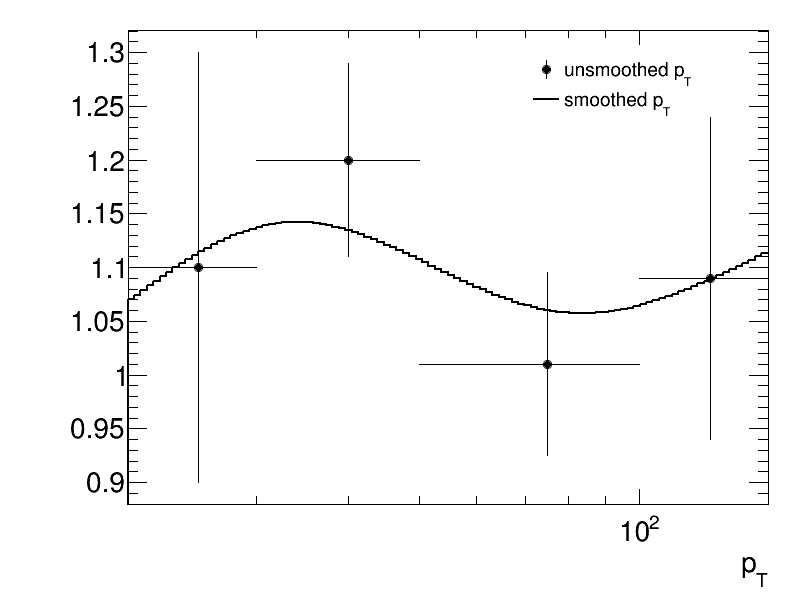

In [16]:
unsmoothed.SetStats(False)
unsmoothed.GetXaxis().SetTitle("p_{T}")
unsmoothed.Draw()
smoothed.SetStats(False)
smoothed.SetTitle("smoothed p_{T}")
smoothed.Draw("same")

leg = Legend([unsmoothed], leftmargin=0.5,
             topmargin=0.04, rightmargin=0.15,
             textsize=20, entryheight=0.1)
leg.AddEntry(smoothed, label=smoothed.GetTitle(), style="l")
leg.Draw()

c.SetLogx(True)
c

## Cross validation of bandwidth

Selecting an appropriate bandwidth is, in general, a domain specific task. Here we explore a leave-one-out cross validation (L1oCV) scheme for selecting a global bandwidth. L1oCV iteratively removes one data point, performs smoothing over the reduced data set, then scores the smoothing by applying some metric to the differnce between the smooth curve and the "left out" data point. The metric we will use is the squared difference. Thus, our final L1oCV score for a given bandwidth, $h$, is:
$$
S(h)=\frac{1}{N_{data}} \sum_i^{N_{data}}{\left(X_i-\hat{m}_{i}\right)^2}
$$
where $\hat{m}_{i}$ is the smoothed curve with data point $i$ removed.

The bandwidth with the lowest L1oCV score is chosen as the "best" bandwidth. This essentially selects the bandwidth that has the best predictive power.

In [15]:
reduced_hists = []
for b in unsmoothed:
    if not b.overflow:
        print unsmoothed.GetBinCenter(b.idx), b.value, b.error

25.0 1.10000002384 0.2
40.0 1.20000004768 0.09
75.0 1.00999999046 0.085
125.0 1.09000003338 0.15
